In [1]:
import os
import numpy as np
import pandas as pd 
import glob
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, LassoCV, ElasticNetCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# start at the project dir
if 'workflow' not in os.listdir():
    os.chdir('../../../')

# setting the output dir
datadir = 'results/processed/harmonized/'
jive_dir = 'results/jive/harmonized/'
outdir = 'results/model_devel/harmonized/'
os.makedirs(outdir, exist_ok=True)

In [2]:
model_dict = {'lr': LinearRegression, 
              'lasso': Lasso,
              'elastic_net': ElasticNet, 
              'lasso_cv': LassoCV,
              'elastic_net_cv': ElasticNetCV}

cmodel = 'lr'
#cmodel = 'lasso'
#cmodel = 'elastic_net'
#cmodel = 'lasso_cv'
#cmodel = 'elastic_net_cv'
cmodel_function = model_dict[cmodel]

## Loading the loading matrices

In [3]:
loadings = {} 
tpl = os.path.join(jive_dir, '*.jive-loadings.tsv')
for loading_fn in glob.glob(tpl):
    
    # load data
    bn = os.path.basename(loading_fn)
    assay = bn.split('.')[0]
    loadings_matrix = pd.read_table(loading_fn)

    # add to dict
    loadings[assay] = loadings_matrix

## Loading the input data

In [4]:
# setting up dictionaries to load data and results
features = {}
outcomes = {}

#### Extracting Features (calculating the reduced form of each omic)

In [5]:
fn = os.path.join(jive_dir, 'common_samples.txt')
with open(fn, 'r') as f:
    common_samples = [int(x.strip()) for x in f.readlines()]

In [6]:
tpl = os.path.join(datadir, 'training_*.tsv')
for raw_fn in glob.glob(tpl):  
    
    bn = os.path.basename(raw_fn)
    assay = bn.split('.')[0].replace('training_', '')
    
    print(assay)
    
    # Loading the raw matrices
    raw = pd.read_table(raw_fn, index_col=0, header=0)
    shared_columns = loadings[assay].index.tolist()
    raw = raw.loc[common_samples, shared_columns]
    raw_array = np.matrix(raw.values)
    
    ## Calculating the sample factor matrix
    loadings_array = np.matrix(loadings[assay].values)
    sample_factors = raw_array * loadings_array

    tdf = pd.DataFrame(sample_factors) 
    tdf.columns = ['{}-{}'.format(assay, i) for i in range(sample_factors.shape[1])]
    features[assay] = tdf
    features[assay].index = raw.index.tolist()

pbmc_cell_frequency
pbmc_gene_expression
plasma_antibody_levels
plasma_cytokine_concentrations


In [7]:
raw

,p05231,p51671,p22301,p48061,p10145,p80098,p01133,p13232,p13500,o14625,...,p13236,p14210,p02778,p10147,p01579,p39900,p15692,p05112,p01375,p09603
subject_id,,,,,,,,,,,,,,,,,,,,,
31,2.57307,8.59856,3.74266,1.16403,6.87546,2.70047,9.84381,4.33103,10.13134,10.66017,...,7.33669,7.52707,7.57017,5.16751,1.21747,5.12582,8.45031,-0.13459,1.40285,7.67584
15,2.64932,9.12795,4.03578,1.16403,5.99654,3.14737,9.68254,3.79068,10.63419,9.93890,...,7.41106,7.03595,7.96844,5.35754,1.21747,4.96235,7.82535,-0.13459,1.40285,7.67979
21,2.21544,8.95975,3.17308,1.16403,5.70083,2.58453,9.28228,4.55338,10.17976,9.47875,...,7.04865,6.91173,6.86485,5.22709,1.21747,5.11631,7.95680,-0.13459,1.40285,7.71481
20,2.67175,9.17883,4.34676,1.19828,4.97702,2.87959,8.66343,3.39323,10.76542,10.43840,...,7.31207,6.60729,7.18416,5.36385,1.21747,4.93213,7.52539,-0.13459,1.40285,7.73569
72,7.29108,291.85182,7.94721,203.91373,3.49160,1.39269,81.81067,0.40026,254.89778,446.13107,...,45.09708,119.89970,60.21940,3.37874,0.21984,256.33011,189.02186,0.02650,10.55859,128.92522
69,2.06559,266.45248,3.77760,164.19256,6.98744,1.68565,140.60198,0.73955,250.03884,452.95417,...,57.87799,123.61731,83.89545,3.07411,0.06360,214.79535,136.43209,0.03707,11.17077,107.21364
85,0.99339,237.71965,6.13223,246.34695,4.75167,1.43653,319.42696,0.84826,217.23230,524.24945,...,76.31793,131.59723,73.22903,3.92546,0.23768,364.21272,155.14589,0.01094,12.23777,117.39623
92,8.44607,227.33345,12.09750,252.33702,4.21767,3.09134,182.53117,0.71815,408.01615,282.67683,...,37.81283,157.55629,82.60534,3.35079,0.31916,335.29368,178.05979,0.01010,12.33266,128.29492
66,11.74543,53.77182,3.89090,188.82478,4.82335,0.70482,368.91671,0.91124,279.09629,174.14060,...,67.96056,150.15630,83.19056,5.80710,0.34091,200.60332,228.75458,0.00990,12.60116,119.57524


In [8]:
features['final'] = pd.concat([features['pbmc_cell_frequency'],
                                     features['plasma_cytokine_concentrations'],
                                     features['pbmc_gene_expression'],
                                     features['plasma_antibody_levels']], axis=1)

In [9]:
features['final'].head()

,pbmc_cell_frequency-0,pbmc_cell_frequency-1,pbmc_cell_frequency-2,pbmc_cell_frequency-3,pbmc_cell_frequency-4,pbmc_cell_frequency-5,pbmc_cell_frequency-6,pbmc_cell_frequency-7,pbmc_cell_frequency-8,pbmc_cell_frequency-9,...,plasma_antibody_levels-0,plasma_antibody_levels-1,plasma_antibody_levels-2,plasma_antibody_levels-3,plasma_antibody_levels-4,plasma_antibody_levels-5,plasma_antibody_levels-6,plasma_antibody_levels-7,plasma_antibody_levels-8,plasma_antibody_levels-9
31,9.083610,-0.462096,10.337036,4.260137,-32.796321,0.172084,-25.785426,4.374064,9.911269,-15.731880,...,0.036292,1.940398,-0.566566,0.246487,-0.661272,-0.321034,-1.272382,0.414521,0.255093,-0.356062
15,4.022152,4.055852,7.126219,2.782571,-21.725112,7.975466,-24.065122,6.053349,11.367983,-11.877017,...,-4.302715,-1.177101,0.286472,-2.460707,3.402857,3.517777,-3.001143,0.533420,4.192523,-1.824346
21,-1.976920,1.267354,5.679265,1.865584,-15.532700,2.905285,-16.430587,8.328064,11.241613,-1.257318,...,-4.519334,8.217305,4.983049,-0.685703,-2.091182,-1.942848,-2.940647,7.028254,4.288550,2.380629
20,-1.156982,3.179306,6.058259,3.293244,-14.595668,4.867394,-20.321299,10.406801,13.144273,-3.581408,...,4.887935,-2.813495,1.881544,-0.958646,0.116316,-0.662331,-1.721881,0.706948,0.493968,1.080263
72,2.004082,6.989833,11.409399,8.707385,-16.001405,6.525344,-24.286423,13.733439,19.011878,-10.089644,...,-4.798742,-19.567265,-2.588458,-1.951887,-6.128855,-4.283021,-4.099539,-8.174419,2.523569,-8.185369


#### Extracting Outcomes

In [10]:
fn = os.path.join(datadir, 'task_matrix.tsv')
outcomes = pd.read_table(fn)
outcomes = outcomes.loc[outcomes.subject_id.isin(common_samples)]

# remove day0
keep_cols = [x for x in outcomes.columns.tolist() if 'day0' not in x]
outcomes = outcomes[keep_cols]

# set index
outcomes.set_index('subject_id', inplace=True)


In [11]:
outcomes.shape

(53, 6)

In [12]:
outcomes.head()

,igg_pt_day14,igg_pt_day14_fold_change,monocytes_day1,monocytes_day1_fold_change,ccl3_day3,ccl3_day3_fold_change
subject_id,,,,,,
15,5.476876,18.120400,10.585489,0.676935,31.757,1.152328
20,7.263459,1.495384,26.605583,1.243300,43.190,2.958219
21,1.927673,0.329951,34.812168,2.286266,23.983,1.823248
31,1.798734,14.802375,8.545243,1.751425,49.266,1.980543
63,16.999568,6.877260,18.700000,1.222222,59.573,0.581824


## Modeling 

#### Extracting Train/Test Splits 

In [13]:
# constructing the model object
# use max_iter as needed
if cmodel in ['lr']:
    lr_model = cmodel_function()
elif cmodel in ['lasso', 'elastic_net', 'lasso_cv', 'elastic_net_cv']:
    lr_model = cmodel_function(max_iter=100000)

# setting up necessary vars/objs
results = []
cv_splitter = KFold(5)
cv_splitter.get_n_splits(features['final'], outcomes)

for task in outcomes.columns.tolist()[1:]:
    
    # get the current training data
    curr_outcomes = outcomes[task].dropna()
    curr_samples = curr_outcomes.index.tolist()
    curr_features = features['final'].loc[curr_samples]

    for i, (train_index, test_index) in enumerate(cv_splitter.split(curr_features)):
        
        # extracting each split of the data
        X_train = curr_features.iloc[train_index]
        X_test = curr_features.iloc[test_index]
        y_train = curr_outcomes.iloc[train_index]
        y_test = curr_outcomes.iloc[test_index]

        # fit the model
        lr_model.fit(X_train.values, y_train.values)

        # make predictions for the test features
        preds = lr_model.predict(X_test.values)
        
        # calculate spearman'
        corr = scipy.stats.spearmanr(y_test.values, preds) 
        results.append([task, i, corr.correlation, corr.pvalue])
    


In [14]:
# convert the results into a df
results_df = pd.DataFrame(results)
results_df.columns = ['task', 'cv', 'spearman_coef', 'pvalue']

In [15]:
results_df.head()

,task,cv,spearman_coef,pvalue
0,igg_pt_day14_fold_change,0,-0.006061,0.986743
1,igg_pt_day14_fold_change,1,0.321212,0.365468
2,igg_pt_day14_fold_change,2,0.321212,0.365468
3,igg_pt_day14_fold_change,3,0.224242,0.533401
4,igg_pt_day14_fold_change,4,0.016667,0.966055


In [16]:
task_results = results_df.groupby('task')

In [17]:
summary_df = task_results.spearman_coef.describe().T

In [18]:
summary_df.head()

task,ccl3_day3,ccl3_day3_fold_change,igg_pt_day14_fold_change,monocytes_day1,monocytes_day1_fold_change
count,5.000000,5.000000,5.000000,5.000000,5.000000
mean,-0.046667,-0.010303,0.175455,0.070909,0.076364
std,0.386358,0.341401,0.160493,0.330217,0.335218
min,-0.609091,-0.296970,-0.006061,-0.284848,-0.369697
25%,-0.163636,-0.263636,0.016667,-0.127273,-0.163636


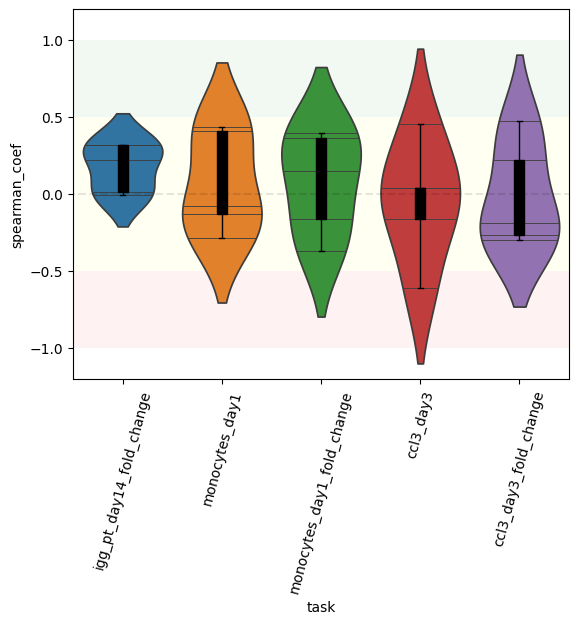

In [19]:
fig, ax = plt.subplots()

# add boundary areas
alpha = 0.05
ax.add_patch(Rectangle((-1, -1), 7, 0.5, facecolor='red', alpha=alpha))
ax.add_patch(Rectangle((-1, -0.5), 7, 1, facecolor='yellow', alpha=alpha))
ax.add_patch(Rectangle((-1, 0.5), 7, 0.5, facecolor='green', alpha=alpha))

# add lines
alpha = 0.1
ls = 'dashed'
ax.hlines(y=0, xmin=-1, xmax=6, color='black', alpha=alpha, linestyles=ls)
ax.set_ylim(-1.2, 1.2)

# add main plots
sns.violinplot(x='task', y='spearman_coef', hue='task', data=results_df, inner='stick', cut=1.75, ax=ax)
sns.boxplot(x='task', y='spearman_coef', color='black', data=results_df, width=0.1, saturation=0.1, whis=20, ax=ax)

# rotate xticks
ax.tick_params(axis='x', labelrotation=75)

fig_fn = os.path.join(outdir, 'fivefold-cross-validation.violinplot.{}.png'.format(cmodel))
fig.savefig(fig_fn, dpi=600)